In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="7"

import tensorflow as tf
from keras import backend as K
print(tf.__version__)
print(K.tensorflow_backend._get_available_gpus())

Using TensorFlow backend.


1.10.0
['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
import os
from tensorflow import keras
import numpy as np
import urllib.request
import pandas as pd
from gensim.test.utils import common_texts, get_tmpfile
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from tempfile import gettempdir
import zipfile
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from numpy.random import seed
from tensorflow import set_random_seed

RANDOM_SEED = 20190101

def set_random(random_seed):
    seed(random_seed)
    set_random_seed(random_seed)

set_random(RANDOM_SEED)

In [4]:
class EmoIntDataset(object):
  BASE_URL = "http://saifmohammad.com/WebDocs/"
  TRAIN_URI = "EmoInt%20Train%20Data/{}-ratings-0to1.train.txt"
  TEST_URI = "EmoInt%20Test%20Gold%20Data/{}-ratings-0to1.test.gold.txt"
  EMOTION_CLASSES = ["anger", "fear", "joy", "sadness"]
  
  THRESHOLD = 0.33
  
  def __load_data_per_class(self, url, threshold=0):
    resource = urllib.request.urlopen(url)
    np_array = np.asarray([line.split('\t') for line in [line.strip() for line in resource.read().decode('utf-8').splitlines()]])
    df = pd.DataFrame(np_array, columns=["id", "text", "emotion", "emotion_level"])
    df['emotion_level'] = df['emotion_level'].astype(float)
    df = df.query('emotion_level>' + str(threshold))
    return df[["text", "emotion"]]
  
  def load_data(self, set_threshold=False):
    train_data = None
    test_data = None
    
    for emotion in self.EMOTION_CLASSES:
      # load train dataset
      train_df = self.__load_data_per_class(self.BASE_URL + self.TRAIN_URI.format(emotion), threshold=(self.THRESHOLD if set_threshold else 0))
      
      # load test dataset
      test_df = self.__load_data_per_class(self.BASE_URL + self.TEST_URI.format(emotion), threshold=(self.THRESHOLD if set_threshold else 0))
      
      train_data = (train_df if train_data is None else train_data.append(train_df))
      test_data = (test_df if test_data is None else test_data.append(test_df))
      
    return train_data, test_data

In [5]:
emo_int_dataset = EmoIntDataset()
train_data, test_data = emo_int_dataset.load_data(set_threshold=True)
train_data, valid_data = train_test_split(train_data, test_size=0.1, random_state=200, stratify=train_data.emotion)

print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

(2610, 2)
(291, 2)
(2508, 2)


In [6]:
emotions = train_data.emotion.unique()
dic = dict()
labels = []
for i, emotion in enumerate(emotions):
    dic[emotion]=i
    labels.append(emotion)
print(dic)
print(labels)

{'fear': 0, 'anger': 1, 'sadness': 2, 'joy': 3}
['fear', 'anger', 'sadness', 'joy']


In [7]:
NUM_WORDS=20000
texts = train_data.text
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower=True)
tokenizer.fit_on_texts(texts)
sequences_train = tokenizer.texts_to_sequences(texts)
sequences_valid = tokenizer.texts_to_sequences(valid_data.text)
sequences_test = tokenizer.texts_to_sequences(test_data.text)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 8672 unique tokens.


In [8]:
X_train = pad_sequences(sequences_train)
X_val = pad_sequences(sequences_valid, maxlen=X_train.shape[1])
X_test = pad_sequences(sequences_test, maxlen=X_train.shape[1])

y_train = to_categorical(np.asarray(train_data.emotion.apply(lambda x:dic[x])))
y_val = to_categorical(np.asarray(valid_data.emotion.apply(lambda x:dic[x])))
y_test = to_categorical(np.asarray(test_data.emotion.apply(lambda x:dic[x])))

print('Shape of X train, validation and test tensor:', X_train.shape, X_val.shape, X_test.shape)
print('Shape of label train, validation and test tensor:', y_train.shape, y_val.shape, y_test.shape)

Shape of X train, validation and test tensor: (2610, 33) (291, 33) (2508, 33)
Shape of label train, validation and test tensor: (2610, 4) (291, 4) (2508, 4)


In [9]:
np.save("emoint_X_train.npy", X_train)
np.save("emoint_X_val.npy", X_val)
np.save("emoint_X_test.npy", X_test)

np.save("emoint_y_train.npy", y_train)
np.save("emoint_y_val.npy", y_val)
np.save("emoint_y_test.npy", y_test)

## Word Embedding using Glove trained in Twitter

In [ ]:
import requests

url = 'http://nlp.stanford.edu/data/glove.twitter.27B.zip'
r = requests.get(url, allow_redirects=True)
open('glove.twitter.27B.zip', 'wb').write(r.content)

In [ ]:
!ls -lA

In [ ]:
!mv glove.twitter.27B.zip ../../Datasets/WordEmbeddings/glove.twitter.27B.zip
!unzip ../../Datasets/WordEmbeddings/glove.twitter.27B.zip

### Convert Glove.Twitter to Word2Vec

In [ ]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = "../../Datasets/WordEmbeddings/glove.twitter.27B.200d.txt"
tmp_glove_file = "../../Datasets/WordEmbeddings/glove.word2vec.twitter.27B.200d.txt"

glove2word2vec(glove_file, tmp_glove_file)

In [10]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('../../Datasets/WordEmbeddings/glove.word2vec.twitter.27B.200d.txt', binary=False)

EMBEDDING_DIM=200
vocabulary_size = min(len(word_index)+1, NUM_WORDS)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i] = np.random.normal(0,np.sqrt(0.25), EMBEDDING_DIM)

del(word_vectors)

In [11]:
file_embedded_matrix = "emoint_embedded_matrix_glove_twitter.npy"
np.save(file_embedded_matrix, embedding_matrix)

## Reload the embedded layer and training dataset

In [12]:
file_embedded_matrix = "emoint_embedded_matrix_glove_twitter.npy"
embedding_matrix = np.load(file_embedded_matrix)
print("embedding matrix shape:", embedding_matrix.shape)

embedding matrix shape: (8673, 200)


In [13]:
X_train = np.load("emoint_X_train.npy")
X_val = np.load("emoint_X_val.npy")
X_test = np.load("emoint_X_test.npy")

y_train = np.load("emoint_y_train.npy")
y_val = np.load("emoint_y_val.npy")
y_test = np.load("emoint_y_test.npy")

In [14]:
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout, concatenate, LSTM, SpatialDropout1D, Bidirectional
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, Adadelta, RMSprop
from keras.models import Model
from keras import regularizers
sequence_length = X_train.shape[1]
HIDDEN_DIM = 600
DROPOUT_RATE = 0.2
N_CLASSES = 4
vocabulary_size = embedding_matrix.shape[0]
EMBEDDING_DIM=200

print("sequence length:", sequence_length)

inputs = Input(shape=(sequence_length,), name='input_1')
embedding_layer = Embedding(vocabulary_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=sequence_length, trainable=True, name='embedding')
embedding = embedding_layer(inputs)
spatial_droput = SpatialDropout1D(0.4, name='spatial_dropout')(embedding)
lstm = Bidirectional(LSTM(units=HIDDEN_DIM, dropout=DROPOUT_RATE, recurrent_dropout=DROPOUT_RATE, name='lstm'))(spatial_droput)
output = Dense(units=N_CLASSES, activation='softmax', name='output')(lstm)

model = None 

# this creates a model that includes
model = Model(inputs, output)

model.summary()

sequence length: 33
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 33)                0         
_________________________________________________________________
embedding (Embedding)        (None, 33, 200)           1734600   
_________________________________________________________________
spatial_dropout (SpatialDrop (None, 33, 200)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1200)              3844800   
_________________________________________________________________
output (Dense)               (None, 4)                 4804      
Total params: 5,584,204
Trainable params: 5,584,204
Non-trainable params: 0
_________________________________________________________________


In [15]:
!rm -r tmp
!mkdir tmp
!ls -lA

total 810212
-rw-rw---- 1 david david   175476 Dec 18 15:21 CrowdFlower_Emotion_Analysis_ConvNet.ipynb
drwxrwx--- 2 david david     4096 Jan  7 11:21 data
-rw-rw---- 1 david david 55482008 Dec 21 10:50 emoint_bidirectional_lstm_fasttext_model.h5
-rw-rw---- 1 david david 27745664 Dec 21 10:50 emoint_bidirectional_lstm_fasttext_weights.h5
-rw-rw---- 1 david david 44703608 Jan  7 17:48 emoint_bidirectional_lstm_glove_model.h5
-rw-rw---- 1 david david 22356464 Jan  7 17:48 emoint_bidirectional_lstm_glove_weights.h5
-rw-rw---- 1 david david 55482008 Dec 21 10:25 emoint_bidirectional_lstm_word2vec_model.h5
-rw-rw---- 1 david david 66260408 Jan  7 17:14 emoint_bidirectional_lstm_word2vec_twitter_model.h5
-rw-rw---- 1 david david 33134864 Jan  7 17:14 emoint_bidirectional_lstm_word2vec_twitter_weights.h5
-rw-rw---- 1 david david 27745664 Dec 21 10:25 emoint_bidirectional_lstm_word2vec_weights.h5
-rw-rw---- 1 david david 23554384 Jan  8 12:01 emoint_convnet_fasttext_model.h5
-rw-rw---- 1 david 

In [16]:
adam = Adam(lr=1e-3, decay=0.0)
adadelta = Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['acc'])

filepath="tmp/weights-{epoch:02d}-{val_acc:.2f}.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
callbacks = [early_stopping, model_checkpoint]

history = model.fit(X_train, y_train, batch_size=1000, epochs=100, verbose=1, validation_data=(X_val, y_val), callbacks=callbacks)  # starts training

Train on 2610 samples, validate on 291 samples
Epoch 1/100
2610/2610 [==============================] - 3s 1ms/step - loss: 2.0953 - acc: 0.3019 - val_loss: 1.2358 - val_acc: 0.5120

Epoch 00001: val_acc improved from -inf to 0.51203, saving model to tmp/weights-01-0.51.hdf5
Epoch 2/100
2610/2610 [==============================] - 1s 250us/step - loss: 1.2628 - acc: 0.4563 - val_loss: 1.2234 - val_acc: 0.4983

Epoch 00002: val_acc did not improve from 0.51203
Epoch 3/100
2610/2610 [==============================] - 1s 249us/step - loss: 1.1711 - acc: 0.5310 - val_loss: 1.0510 - val_acc: 0.6254

Epoch 00003: val_acc improved from 0.51203 to 0.62543, saving model to tmp/weights-03-0.63.hdf5
Epoch 4/100
2610/2610 [==============================] - 1s 241us/step - loss: 1.0784 - acc: 0.5544 - val_loss: 1.0477 - val_acc: 0.6151

Epoch 00004: val_acc did not improve from 0.62543
Epoch 5/100
2610/2610 [==============================] - 1s 244us/step - loss: 1.0438 - acc: 0.5766 - val_loss: 0.


Epoch 00040: val_acc did not improve from 0.85223
Epoch 41/100
2610/2610 [==============================] - 1s 246us/step - loss: 0.1925 - acc: 0.9333 - val_loss: 0.4299 - val_acc: 0.8419

Epoch 00041: val_acc did not improve from 0.85223
Epoch 42/100
2610/2610 [==============================] - 1s 244us/step - loss: 0.2486 - acc: 0.9123 - val_loss: 0.4471 - val_acc: 0.8522

Epoch 00042: val_acc did not improve from 0.85223
Epoch 43/100
2610/2610 [==============================] - 1s 258us/step - loss: 0.1830 - acc: 0.9356 - val_loss: 0.4207 - val_acc: 0.8385

Epoch 00043: val_acc did not improve from 0.85223
Epoch 44/100
2610/2610 [==============================] - 1s 256us/step - loss: 0.1688 - acc: 0.9467 - val_loss: 0.4410 - val_acc: 0.8282

Epoch 00044: val_acc did not improve from 0.85223
Epoch 45/100
2610/2610 [==============================] - 1s 239us/step - loss: 0.1616 - acc: 0.9429 - val_loss: 0.4225 - val_acc: 0.8694

Epoch 00045: val_acc improved from 0.85223 to 0.86942,

In [17]:
model_path = 'emoint_bidirectional_lstm_glove_model.h5'
weight_path = 'emoint_bidirectional_lstm_glove_weights.h5'

model.save(model_path)
model.save_weights(weight_path)

In [18]:
!ls -lah

total 792M
drwxrwx--- 7 david david  12K Jan  8 13:38 .
drwxrwx--- 3 david david 4.0K Dec 18 16:51 ..
-rw-rw---- 1 david david 172K Dec 18 15:21 CrowdFlower_Emotion_Analysis_ConvNet.ipynb
drwxrwx--- 2 david david 4.0K Jan  7 11:21 data
-rw-rw---- 1 david david  53M Dec 21 10:50 emoint_bidirectional_lstm_fasttext_model.h5
-rw-rw---- 1 david david  27M Dec 21 10:50 emoint_bidirectional_lstm_fasttext_weights.h5
-rw-rw---- 1 david david  43M Jan  8 13:38 emoint_bidirectional_lstm_glove_model.h5
-rw-rw---- 1 david david  22M Jan  8 13:38 emoint_bidirectional_lstm_glove_weights.h5
-rw-rw---- 1 david david  53M Dec 21 10:25 emoint_bidirectional_lstm_word2vec_model.h5
-rw-rw---- 1 david david  64M Jan  7 17:14 emoint_bidirectional_lstm_word2vec_twitter_model.h5
-rw-rw---- 1 david david  32M Jan  7 17:14 emoint_bidirectional_lstm_word2vec_twitter_weights.h5
-rw-rw---- 1 david david  27M Dec 21 10:25 emoint_bidirectional_lstm_word2vec_weights.h5
-rw-rw---- 1 david david  23M Jan  8 12:01 emoint_

In [19]:
sequences_test=tokenizer.texts_to_sequences(test_data.text)
X_test = pad_sequences(sequences_test, maxlen=X_test.shape[1])
y_pred = model.predict(X_test)

In [20]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [21]:
y_pred_original = [labels[val] for val in np.argmax(y_pred, axis=1).squeeze()]
y_test_original = np.asarray(test_data.emotion)

In [22]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (4,3), fontsize=15):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [23]:
cf_matrix = confusion_matrix(y_test_original, y_pred_original, labels=labels)

df_cm = pd.DataFrame(
    cf_matrix, index=labels, columns=labels, 
)

df_cm

,fear,anger,sadness,joy
fear,657,40,66,26
anger,87,496,40,20
sadness,92,22,407,12
joy,40,5,23,475


Figure(288x216)


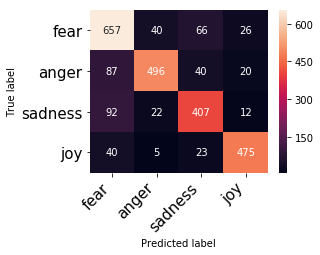

In [24]:
print(print_confusion_matrix(cf_matrix, class_names=labels))

In [25]:
test_accuracy = accuracy_score(y_test_original, y_pred_original)
print("test accuracy:", test_accuracy)

test accuracy: 0.8114035087719298


### Performance score for each classes

In [26]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original)
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support.round(4)
}
score_df = pd.DataFrame(score_dict, index=labels)
score_df

,precision,recall,f1-score,support
fear,0.8810,0.7714,0.8226,643
anger,0.7500,0.8327,0.7892,789
sadness,0.8912,0.8748,0.8829,543
joy,0.7593,0.7636,0.7615,533


### Performance score using micro average

In [27]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="micro")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,precision,recall,f1-score,support
score,0.8114,0.8114,0.8114,None


### Performance score using macro average

In [28]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="macro")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,precision,recall,f1-score,support
score,0.8204,0.8106,0.814,None


### Performance score using weighted average

In [29]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="weighted")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,precision,recall,f1-score,support
score,0.8161,0.8114,0.8121,None


### Cohen Kappa score

In [30]:
from sklearn.metrics import cohen_kappa_score

kappa_score = cohen_kappa_score(y_test_original, y_pred_original, labels=labels)
print("kappa:", kappa_score)

kappa: 0.7455300374277316
